# Assignment Wind and Waves
things to ask:
* Q3 do we need one or two wind profiles (both load cases)? And Kaimal and co-spectra?
* Q3 what should $u_*$ be?
* Q3 $z_0$ 1e-3 (coastal areas, L2S9) or 1e-4 (open seas, but without waves)?
* Q4 scaling of ifft (1/(N*dt))? The amplitudes we obtain seem to be on the low side.
* Q4 how to go from wave height spectrum to load spectra on nodes.

## Question 1 - FEM Model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch
import sympy as sym
import scipy.optimize as opt
import scipy
import math

In [2]:
# General parameters
M_RNA = 550E3           # RNA Mass [kg]
H = 105                 # Hub height [m]
h = 35                  # Water depth [m]
Omega_max = 11.3        # Max rotor speed [rpm]
F = 200E3               # Fetch [m]
U10 = 23                # Wind speed [m/s]

L = H + h               # Total length [m]
d = 7                   # Diameter [m]
t = 0.01 * d            # Thickness [m]
A = np.pi * d * t       # Cross-sectional area [m²]
rho = 7850              # Density [kg/m³]
E = 210E9               # Young's modulus [Pa]
I = np.pi*(d/2)**3*t    # Moment of inertia [m^4]

q = 10                  # Distributed load [N/m]

# Boundary conditions for FEM
u0 = 0          # [m]
u0_dt2 = 0      # [m/s²]
du0 = 0         # [m]
du0_dt2 = 0     # [m/s²]


g = 9.81                # Gravitational acceleration [m/s²]

### Step 1: discretize the domain

In [3]:
ne = 12
nn = ne + 1
ndofs = 2*nn
xn = np.linspace(0, L, nn)

l_elem = L/12

print(xn)

[  0.          11.66666667  23.33333333  35.          46.66666667
  58.33333333  70.          81.66666667  93.33333333 105.
 116.66666667 128.33333333 140.        ]


In [4]:
elem_dofs = []
dof_node = []
for ie in np.arange(0,ne):
    elem_dofs.append(np.arange(2*ie, 2*ie+4))
for idof in np.arange(0, ndofs):
    dof_node.append(int(np.floor(idof/2)))

In [5]:
# Define Cubic Shape Functions
N_k = []
dN_k = []
ddN_k = []
h_e = L/ne
matrix = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [1, h_e,  h_e**2, h_e**3], [0, 1, 2*h_e, 3*h_e**2]])

def base(x):
    if isinstance(x, float):
        return np.array([[1], [x], [x**2], [x**3]])
    else:
        return np.array([[np.ones(len(x))], [x], [x**2], [x**3]])
def dbase(x):
    if isinstance(x, float):
        return np.array([[0], [1], [2*x], [3*x**2]])
    else:
        return np.array([[np.zeros(len(x))], [np.ones(len(x))], [2*x], [3*x**2]])
def ddbase(x):
    if isinstance(x, float):
        return np.array([[0], [0], [2], [6*x]])
    else:
        return np.array([[np.zeros(len(x))], [np.zeros(len(x))], [2*np.ones(len(x))], [6*x]])
    
def make_N(coeff): 
    return lambda x: np.dot(np.transpose(base(x)), coeff)
def make_dN(coeff):
    return lambda x: np.dot(np.transpose(dbase(x)), coeff)
def make_ddN(coeff):
    return lambda x: np.dot(np.transpose(ddbase(x)), coeff)

dof_vec = np.arange(0,4)
for idof in dof_vec:
    rhs = np.zeros(len(dof_vec))
    rhs[idof] = 1
    coeff = np.linalg.solve(matrix, rhs)
    N_k.append(make_N(coeff))
    dN_k.append(make_dN(coeff))
    ddN_k.append(make_ddN(coeff))

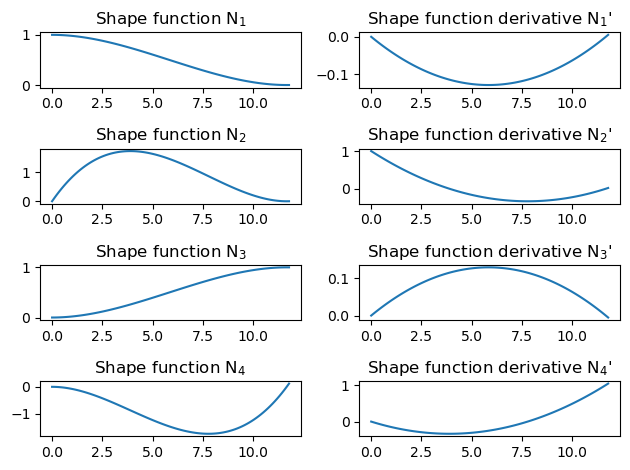

In [6]:
xplot = np.arange(0, h_e + h_e/100, h_e/100)

fig, axs = plt.subplots(4, 2)
axs[0, 0].plot(xplot, N_k[0](xplot))
axs[0, 0].set_title("Shape function N$_1$")
axs[0, 1].plot(xplot, dN_k[0](xplot))
axs[0, 1].set_title("Shape function derivative N$_1$'")
axs[1, 0].plot(xplot, N_k[1](xplot))
axs[1, 0].set_title("Shape function N$_2$")
axs[1, 1].plot(xplot, dN_k[1](xplot))
axs[1, 1].set_title("Shape function derivative N$_2$'")
axs[2, 0].plot(xplot, N_k[2](xplot))
axs[2, 0].set_title("Shape function N$_3$")
axs[2, 1].plot(xplot, dN_k[2](xplot))
axs[2, 1].set_title("Shape function derivative N$_3$'")
axs[3, 0].plot(xplot, N_k[3](xplot))
axs[3, 0].set_title("Shape function N$_4$")
axs[3, 1].plot(xplot, dN_k[3](xplot))
axs[3, 1].set_title("Shape function derivative N$_4$'")

# automatically fix subplot spacing
plt.tight_layout()

In [7]:
import scipy.integrate as scp
M_k = np.zeros((4, 4))
K_k = np.zeros((4, 4))
Q_k = np.zeros(4)

for idof in np.arange(0, 4):
    for jdof in np.arange(0, 4):
        def eqn_M(x):
            return rho*A*N_k[idof](x)*N_k[jdof](x)
        def eqn_K(x): 
            return E*I*ddN_k[idof](x)*ddN_k[jdof](x)
        def eqn_Q(x):
            return q*N_k[idof](x)
            
        M_k[idof, jdof] = scp.quad(eqn_M, 0, h_e)[0]
        K_k[idof, jdof] = scp.quad(eqn_K, 0, h_e)[0]
        Q_k[idof] = scp.quad(eqn_Q, 0, h_e)[0]

In [8]:
K = np.zeros((ndofs*ndofs))       # 1-D array for global stiffness matrix
M = np.zeros((ndofs*ndofs))       # 1-D array for global mass matrix
Q = np.zeros(ndofs)               # 1-D array for Q vector

for ie in np.arange(0, ne):
    # Get the nodes of the elements
    dofs = elem_dofs[ie]
    NodeLeft = dof_node[dofs[0]]
    NodeRight = dof_node[dofs[-1]]
    
    # Get the degrees of freedom that correspond to each node
    Dofs_Left = 2*(NodeLeft) + np.arange(0, 2)
    Dofs_Right = 2*(NodeRight) + np.arange(0, 2)

    # Assemble the matrices at the correct place
    nodes = np.append(Dofs_Left, Dofs_Right)
    for i in np.arange(0, 4):
        Q[nodes[i]] = Q[nodes[i]] + Q_k[i]
        for j in np.arange(0, 4):
            ij = nodes[j] + nodes[i]*ndofs
            M[ij] = M[ij] + M_k[i, j]
            K[ij] = K[ij] + K_k[i, j]
            
# Reshape the global matrix from a 1-D array to a 2-D array
M = M.reshape((ndofs, ndofs))
K = K.reshape((ndofs, ndofs))

# Add RNA mass to the last node
M[-2, -2] = M_RNA

Q

array([ 5.83333333e+01,  1.13425926e+02,  1.16666667e+02, -4.54747351e-13,
        1.16666667e+02, -4.54747351e-13,  1.16666667e+02, -4.54747351e-13,
        1.16666667e+02, -4.54747351e-13,  1.16666667e+02, -4.54747351e-13,
        1.16666667e+02, -4.54747351e-13,  1.16666667e+02, -4.54747351e-13,
        1.16666667e+02, -4.54747351e-13,  1.16666667e+02, -4.54747351e-13,
        1.16666667e+02, -4.54747351e-13,  1.16666667e+02, -4.54747351e-13,
        5.83333333e+01, -1.13425926e+02])

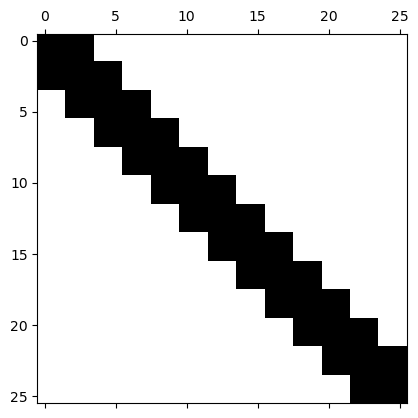

In [9]:
plt.figure()
plt.spy(M);

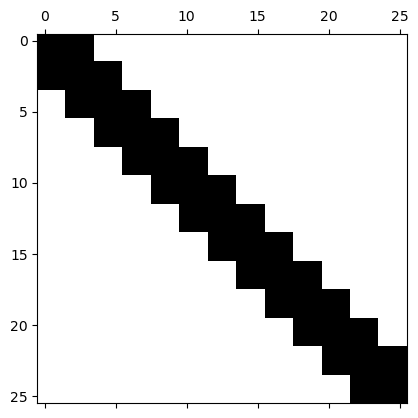

In [10]:
plt.figure()
plt.spy(K);

In [11]:
fixed_dofs = np.arange(0, 2)                    # fixed DOFs
free_dofs = np.arange(0, ndofs)                 # free DOFs
free_dofs = np.delete(free_dofs, fixed_dofs)    # remove the fixed DOFs from the free DOFs array

# free & fixed array indices
fx = free_dofs[:, np.newaxis]
fy = free_dofs[np.newaxis, :]
bx = fixed_dofs[:, np.newaxis]
by = fixed_dofs[np.newaxis, :]

# Mass
Mii = M[fx, fy]
Mib = M[fx, by]
Mbi = M[bx, fy]
Mbb = M[bx, by]

# Stiffness
Kii = K[fx, fy]
Kib = K[fx, by]
Kbi = K[bx, fy]
Kbb = K[bx, by]

Qii = Q[fy]
Qbb = Q[by]

Qii

array([[ 1.16666667e+02, -4.54747351e-13,  1.16666667e+02,
        -4.54747351e-13,  1.16666667e+02, -4.54747351e-13,
         1.16666667e+02, -4.54747351e-13,  1.16666667e+02,
        -4.54747351e-13,  1.16666667e+02, -4.54747351e-13,
         1.16666667e+02, -4.54747351e-13,  1.16666667e+02,
        -4.54747351e-13,  1.16666667e+02, -4.54747351e-13,
         1.16666667e+02, -4.54747351e-13,  1.16666667e+02,
        -4.54747351e-13,  5.83333333e+01, -1.13425926e+02]])

### Step 2: Find Natural Frequencies

In [12]:
from scipy.linalg import eigh

eigenvalues_scipy, eigenvectors_scipy = eigh(Kii, Mii)
omega_scipy = np.sort(np.sqrt(eigenvalues_scipy.real))
f_scipy = omega_scipy / (2 * np.pi)
print("First 5 natural frequencies (using scipy.linalg.eigh):")
for i in np.arange(0, 5):
    print(f"Frequency {i+1}: {f_scipy[i]:.2f} Hz, {omega_scipy[i]:.2f} rad/s")
print()

mat = np.dot(np.linalg.inv(Mii), Kii)
eigenvalues, eigenvectors = np.linalg.eig(mat)
omega_eigen = np.sort(np.sqrt(eigenvalues.real))
f_eigen = omega_eigen/2/np.pi

print("First 5 natural frequencies:")
for i in np.arange(0,5):
    print(f"Frequency {i+1}: {f_eigen[i]:.2f} Hz, {omega_eigen[i]:.2f} rad/s")
    
print()
print(f"Omega_max: {Omega_max:.2f} rpm")
print(f"Omega_max: {Omega_max/60:.2f} Hz")
print(f"Omega_max: {2*np.pi*Omega_max/60:.2f} rad/s")

First 5 natural frequencies (using scipy.linalg.eigh):
Frequency 1: 0.25 Hz, 1.55 rad/s
Frequency 2: 1.83 Hz, 11.50 rad/s
Frequency 3: 5.47 Hz, 34.39 rad/s
Frequency 4: 11.14 Hz, 69.99 rad/s
Frequency 5: 18.86 Hz, 118.50 rad/s

First 5 natural frequencies:
Frequency 1: 0.25 Hz, 1.55 rad/s
Frequency 2: 1.83 Hz, 11.50 rad/s
Frequency 3: 5.47 Hz, 34.39 rad/s
Frequency 4: 11.14 Hz, 69.99 rad/s
Frequency 5: 18.86 Hz, 118.50 rad/s

Omega_max: 11.30 rpm
Omega_max: 0.19 Hz
Omega_max: 1.18 rad/s


In [13]:
# Rayleigh Damping
zeta1 = zeta2 = 0.02

A_mat = np.array([
    [1/(2*omega_eigen[0]), omega_eigen[0]/2],
    [1/(2*omega_eigen[1]), omega_eigen[1]/2]
])
b_vec = np.array([zeta1, zeta2])

alpha_d, beta_d = np.linalg.solve(A_mat, b_vec)
print("alpha_d = ", alpha_d)
print("beta_d = ", beta_d)
C_d = alpha_d*M + beta_d*K
Cii = C_d[np.ix_(free_dofs, free_dofs)]

Cii

alpha_d =  0.054619150945627276
beta_d =  0.003065838745751389


array([[ 9.17526462e+07,  9.35452824e-08, -4.58724729e+07,
         2.67592420e+08,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 9.35452824e-08,  4.16261197e+09, -2.67592420e+08,
         1.04064052e+09,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-4.58724729e+07, -2.67592420e+08,  9.17526462e

### Step 3: Sanity Checks

**Complete with analytical expressions and calculations to be compared with the following results**

The displacements resulting from the model are hereby compared with analytical results for a cantilever beam in order to validate the FE implementation.


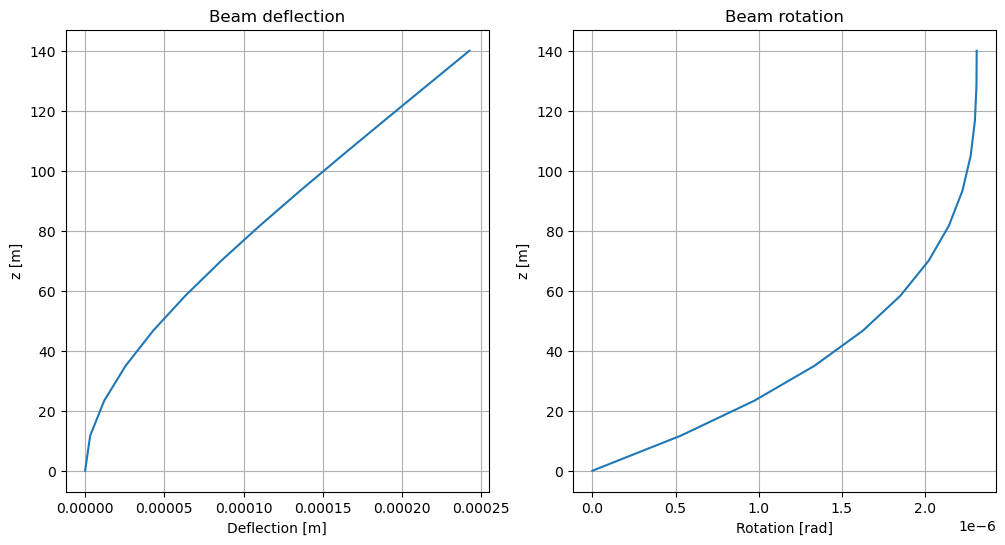

In [14]:
# Solve for displacements
u = Qii @ np.linalg.inv(Kii)

# Add fixed boundary conditions back in
u_full = np.insert(u, 0, [0,0])

# Plot results
fig, ax = plt.subplots(1,2, figsize=(12, 6))
ax[0].plot(u_full[::2], xn)
ax[0].set_ylabel('z [m]')
ax[0].set_xlabel("Deflection [m]")
ax[0].set_title("Beam deflection");
ax[0].grid()

ax[1].plot(u_full[1::2], xn)
ax[1].set_ylabel('z [m]')
ax[1].set_xlabel("Rotation [rad]")
ax[1].set_title("Beam rotation");
ax[1].grid()


## Question 2: Monopile Diameter Tuning
In order to avoid resonances the first natural frequency of the structure must not coincide with the rotor frequency ($\Omega_{max}$). 
The radius of the monopile is therefore tuned to return a natural frequency approximatedly 10% higher than the 1P frequency ($\Omega_{max}$). 
An arbitrary $D/t$ ratio of 100 was chosen as design parameter. 
A radius of 3.5m was chosen which returns a natural frequency of 0.25 Hz, which is acceptable compared to given $\Omega_{max}$=0.19 Hz. 
Acceptance criterion was a structure natural frequency at least 10% higher than rotor frequency. \
(Previous cells already include the design radius, which was determined by iteration)

#CHECK > Before final delivery make sure radius and frequencies were not modified

## Question 3: Wind and wave co-spectra
Regarding the constants, a few assumptions were made. $u_*$ was chosen as 2.0 m, in accordance with the slides of lecture 2. A roughness length of $z_0$ = 1e-4 m was chosen, as this one is suitable for oceans (see answers to the exercises of lecture 2). Based on these answers, the constant $A$ which is multiplied with $u_*$ to obtain the standard deviation was chosen to be 3 (typically larger than 2.5 for oceans). The constants $C_y$ and $C_z$ are typically 10 (lecture 2). $C$ and $m$ were estimated based on the graph on slide 11 of that lecture, which is depending on $z_0$. For the JONSWAP spectrum, values of $\gamma$ = 3.3 and $\beta$ = 5/4 were used in accordance with lecture 1.

In [15]:
# Question 3 and 4 parameters
u_star = 2              # Friction velocity [m/s]
k = 0.40                # Von-Karman constant
z_0 = 1e-4              # Roughness length [m]
A = 3                   # constant for calculation of sigma_u
C_y = 10                # constant for calculation of non-dimensional cross-spectrum
C_z = 10                # constant for calculation of non-dimensional cross-spectrum
C = 500                 # belonging to z0=1e-3
m = 0.03                # belonging to z0=1e-3
gamma = 3.3             # constant for JONSWAP spectrum
beta = 5 / 4            # constant for JONSWAP spectrum

In [16]:
# SymPy code to obtain an analytical expression for the unknowns for load case 1
# F_tilde, f_p_tilde, U_10, f_p, g, F = sym.symbols('F_tilde f_p_tilde U_10 f_p g F')
# eq1 = sym.Eq(f_p_tilde, U_10 * f_p / g)
# eq2 = sym.Eq(F_tilde, g * F / U_10**2)
# eq3 = sym.Eq(f_p_tilde, 3.5 / F_tilde**0.33)
# sol = sym.solve([eq1, eq2, eq3], (U_10, F_tilde, f_p_tilde), dict=True)
# '''[{
# F_tilde: 0.000630376100157691*F*f_p**2/(g*(g**33/(F**33*f_p**66))**(1/17)),
# U_10: 39.8290667529805*g*(g**33/(F**33*f_p**66))**(1/34)/f_p,
# f_p_tilde: 39.8290667529805*(g**33/(F**33*f_p**66))**(1/34)
# }]'''

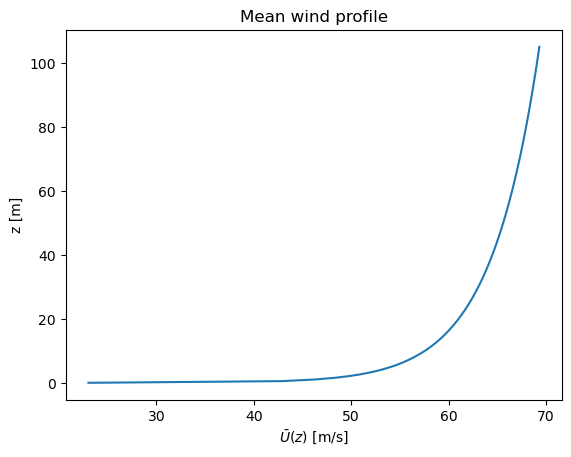

In [17]:
def U_bar(z, u_star, k, z_0):
    return u_star / k * np.log(z / z_0)

z_wind = np.linspace(0.01, H, 200)
U_bar_values = U_bar(z_wind, u_star, k, z_0)
plt.plot(U_bar_values, z_wind)
plt.xlabel('$\\bar{U}(z)$ [m/s]')
plt.ylabel('z [m]')
plt.title('Mean wind profile');

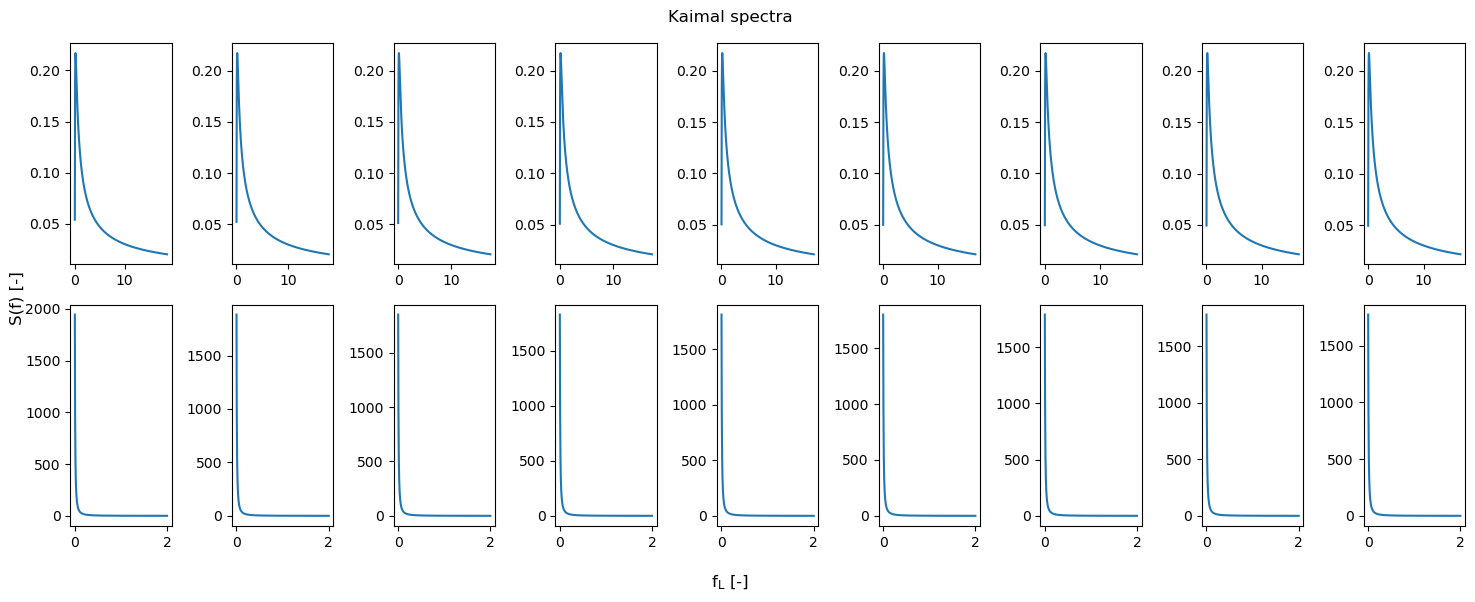

In [18]:
def L_u_x(z, C, m):
    return C * z**m

def Kaimal(z, f, C, m, u_star, k, z_0):
    f_L = f * L_u_x(z, C, m) / U_bar(z, u_star, k, z_0)
    R_N = 6.8 * f_L / (1 + 10.2 * f_L)**(5 / 3)
    return f_L, R_N

z_nodes = np.linspace(-h, H, 13)
z_nodes_air = z_nodes[z_nodes > 0]
f_kaimal = np.linspace(0.001, 2.0, 1000)
S_auto = np.zeros((len(z_nodes_air), len(f_kaimal)))
R_N_auto = np.zeros((len(z_nodes_air), len(f_kaimal)))
f_L = np.zeros(len(f_kaimal))


fig, axes = plt.subplots(2, 9, figsize=(15, 6))
for i,z in enumerate(z_nodes_air):
    f_L, R_N = Kaimal(z, f_kaimal, C, m, u_star, k, z_0)

    I_u = k * A / np.log(z / z_0)
    sigma_u = I_u * U_bar(z, u_star, k, z_0)
    
    S_auto[i] = sigma_u**2 * R_N / f_kaimal
    R_N_auto[i] = R_N

    axes[0][i].plot(f_L, R_N)
    axes[1][i].plot(f_kaimal, S_auto[i])
    
fig.supxlabel('$\\mathrm{f_L}$ [-]')
fig.supylabel('S(f) [-]')
plt.suptitle('Kaimal spectra')
plt.tight_layout()

def wind_cross_spectrum(f):
    S_wind_cross = np.zeros((len(z_nodes_air), len(z_nodes_air), len(f)))
    R_N_wind_cross = np.zeros((len(z_nodes_air), len(z_nodes_air), len(f)))

    for i,S_1 in enumerate(S_auto):
        for j,S_2 in enumerate(S_auto):
            if i == j:
                S_wind_cross[i, j] = S_1
                R_N_wind_cross[i, j] = 1
                continue
            z_i = z_nodes_air[i]
            z_j = z_nodes_air[j]
            r_z = np.abs(z_i - z_j)
            U_b = (U_bar(z_i, u_star, k, z_0) + U_bar(z_j, u_star, k, z_0)) / 2
            psi_u = np.exp(-f / U_b * np.sqrt((C_y * 0)**2 + (C_z * r_z)**2))
            S_cross = psi_u * np.sqrt(S_1 * S_2)
            
            S_wind_cross[i, j] = S_cross
            R_N_wind_cross[i, j] = psi_u
    return S_wind_cross, R_N_wind_cross

S_wind_cross, R_N_wind_cross = wind_cross_spectrum(f_kaimal)


# Plotting the auto- and cross-spectra (commented to save time)

# fig, axes = plt.subplots(len(z_nodes_air), len(z_nodes_air), figsize=(15, 15), sharex=True, sharey=True)

# for i in range(len(S_auto)):
#     for j in range(len(S_auto)):
#         axes[i, j].loglog(f_L, R_N_wind_cross[i, j])

# fig.supxlabel('f [Hz]')
# fig.supylabel('$\\mathrm{S_{uu}(f)}$ [-]')
# fig.suptitle('Auto- and co-spectra')
# fig.tight_layout()

The significant wave height of load case 1 is 0.559 [m].
The significant wave height of load case 2 is 6.237 [m].


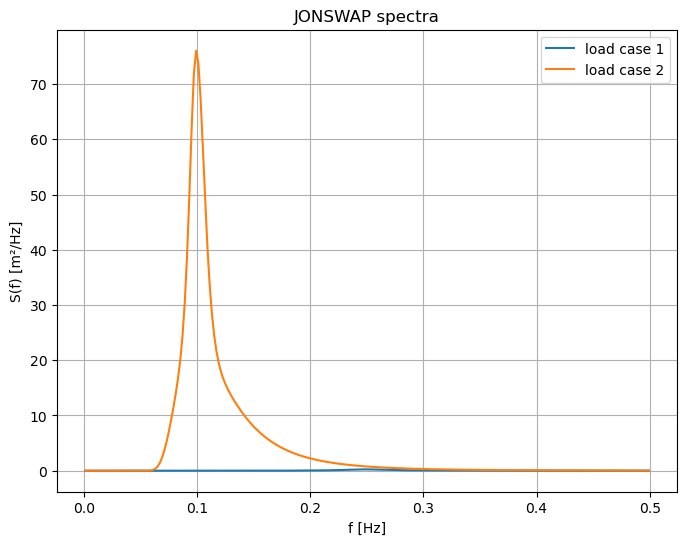

In [19]:
#Load case 1: resonance response
f_p_1 = f_eigen[0]
T_p_1 = 1 / f_p_1
U_10_1 = 39.8290667529805 * g * (g**33 / (F**33 * f_p_1**66))**(1 / 34) / f_p_1
F_tilde_1 = g * F / U_10_1**2
f_p_tilde_1 = 3.5 * F_tilde_1**(-0.33)
alpha_1 = 0.076 * F_tilde_1**(-0.22)

#Load case 2: idling in operational conditions
U_10_2 = 23 #m/s
F_tilde_2 = g * F / U_10_2**2
f_p_tilde_2 = 3.5 * F_tilde_2**(-0.33)
f_p_2 = f_p_tilde_2 * g / U_10_2
T_p_2 = 1 / f_p_2
alpha_2 = 0.076 * F_tilde_2**(-0.22)

def JONSWAP(alpha, g, f, beta, f_p, gamma):
    sigma = 0.07 * np.ones_like(f)
    sigma[f > f_p] = 0.09

    S = alpha * g**2 * (2 * np.pi)**(-4) * f**(-5) * np.exp(-beta * (f / f_p)**(-4)) * gamma**np.exp(-1 / 2 * ((f / f_p - 1) / sigma)**2)
    m_0 = np.trapezoid(S, f)
    H_s = 4 * np.sqrt(m_0)

    return S, H_s

f_jonswap = f_kaimal
f_max_plot = 0.5
S_JS_1, H_s_1 = JONSWAP(alpha_1, g, f_jonswap, beta, f_p_1, gamma)
S_JS_2, H_s_2 = JONSWAP(alpha_2, g, f_jonswap, beta, f_p_2, gamma)

plt.figure(figsize=(8, 6))
plt.plot(f_jonswap[f_jonswap < f_max_plot], S_JS_1[f_jonswap < f_max_plot], label='load case 1')
plt.plot(f_jonswap[f_jonswap < f_max_plot], S_JS_2[f_jonswap < f_max_plot], label='load case 2')
plt.title('JONSWAP spectra')
plt.xlabel('f [Hz]')
plt.ylabel('S(f) [m²/Hz]')
plt.legend()
plt.grid()

print(f'The significant wave height of load case 1 is {H_s_1:.3f} [m].')
print(f'The significant wave height of load case 2 is {H_s_2:.3f} [m].')

## Question 4: Wind and waves timeseries and convergence analysis

Generate times series for wind and waves (plus convergence analysis) 


Based on the Kaimal and JONSWAP spectra, times series of the wind and wave kinematics are 
determined for each node of the finite element model. To this end, random phase angle 
distributions can be adopted. Time series representations should be sufficiently long to capture 
the statistical properties of the applied wind and wave spectra. Furthermore, the sampling 
period should be sufficiently small to adequately capture the first and second mode of the 
structure

In [20]:
# Function for generating time series from a 1 dimensional spectrum
def generate_time_series(S, f):
    N = len(f)
    df = f[1] - f[0]  # Frequency resolution
    fs = df * N  # Sampling frequency
    
    complex_fourier_coefficients = np.zeros((N), dtype=complex)
    
    # for every frequency
    for i in range(N):
        S_n = S[i]
        
        random_phase = np.random.uniform(0, 2 * np.pi)
        random_phase_vector = np.exp(1j * random_phase)
        
        A_n = np.sqrt(2*S_n*df)
        
        X_n = A_n * random_phase_vector
        
        complex_fourier_coefficients[i] = X_n
        
    dt = 1 / fs  # Time step
    time = np.arange(0, 2*N*dt+dt/2, dt)  # Time vector
    
    X_complex = 2 * N * np.concatenate(([0+0j], complex_fourier_coefficients, np.conjugate(complex_fourier_coefficients[::-1])))
    
    time_series = np.fft.ifft(X_complex)
    return time, time_series.real

z = 11.67 m: sigma_u (theory) = 6.00, sigma_u (sim) = 5.90
z = 23.33 m: sigma_u (theory) = 6.00, sigma_u (sim) = 6.09
z = 35.00 m: sigma_u (theory) = 6.00, sigma_u (sim) = 6.03
z = 46.67 m: sigma_u (theory) = 6.00, sigma_u (sim) = 5.84
z = 58.33 m: sigma_u (theory) = 6.00, sigma_u (sim) = 5.90
z = 70.00 m: sigma_u (theory) = 6.00, sigma_u (sim) = 5.82
z = 81.67 m: sigma_u (theory) = 6.00, sigma_u (sim) = 5.64
z = 93.33 m: sigma_u (theory) = 6.00, sigma_u (sim) = 5.61
z = 105.00 m: sigma_u (theory) = 6.00, sigma_u (sim) = 5.47


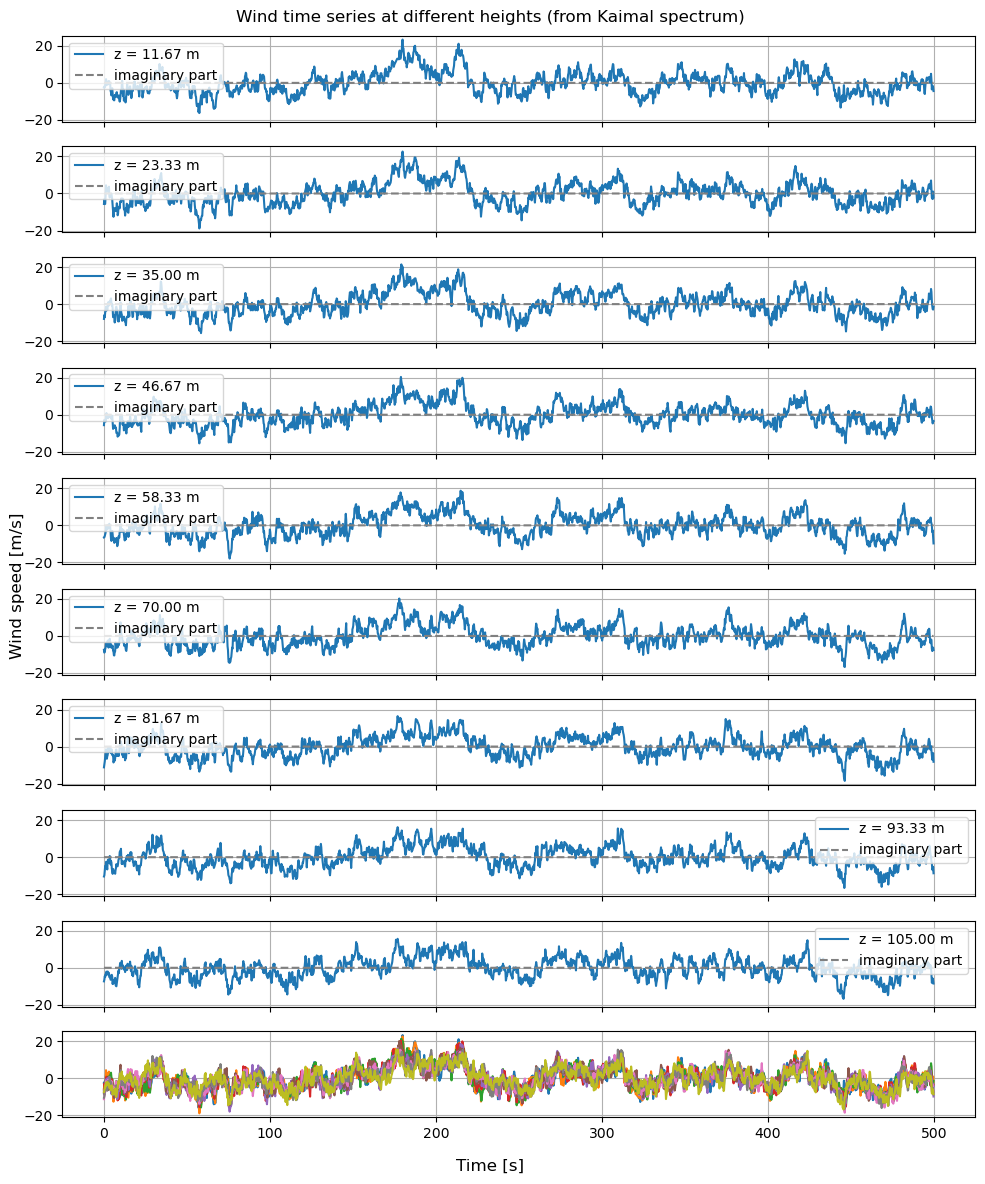

In [21]:
# Bart; attempt at question 4 kaimal spectrum
# not sure about the last step involving the ifft and the time vector. i think it is correct now just not sure about the amplitude scaling

N = len(f_kaimal)  # Number of frequency bins
df = f_kaimal[1] - f_kaimal[0]  # Frequency step size
fs = df * N * 2 # Frequency resolution


complex_fourier_coefficients_kaimal = np.zeros((len(z_nodes_air), len(f_kaimal)), dtype=complex)

# for every frequency
for i in range(N):
    R_n = R_N_wind_cross[:, :, i]
    S_n = S_wind_cross[:, :, i]
  
    random_phase = np.random.uniform(0, 2 * np.pi, size=len(S_n[0]))
    random_phase_vector = np.exp(1j * random_phase)
        
    H_n = np.linalg.cholesky(R_n)
    
    V_n = H_n @ random_phase_vector
    
    mask = np.eye(len(S_n))
    
    A_n = np.sqrt(2 * S_n * df) * mask
    
    X_n = A_n @ V_n
    
    complex_fourier_coefficients_kaimal[:, i] = X_n

dt = 1 / fs
time = np.arange(0, 2*N * dt+dt/2, dt)

fig, ax = plt.subplots(10, 1, figsize=(10, 12), sharex=True, sharey=True)
wind_turbulence = np.zeros((len(z_nodes_air), len(time)))

for i in range(len(z_nodes_air)):    
    X_complex = N * np.concatenate(([0+0j], complex_fourier_coefficients_kaimal[i], np.conjugate(complex_fourier_coefficients_kaimal[i][::-1])))
    time_series = np.fft.ifft(X_complex).real
    wind_turbulence[i] = time_series
    
    ax[i].plot(time, time_series.real, label=f'z = {z_nodes_air[i]:.2f} m')
    ax[i].plot(time, time_series.imag, color='gray', label=f'imaginary part', linestyle='--')
    ax[i].legend()
    ax[i].grid()
    
    ax[9].plot(time, time_series.real)

ax[9].grid()

fig.suptitle('Wind time series at different heights (from Kaimal spectrum)')
fig.supxlabel('Time [s]')
fig.supylabel('Wind speed [m/s]')
fig.tight_layout()

# Check the amplitude scaling of the generated turbulence time series

# The standard deviation of the turbulence at each height should match the theoretical value sigma_u
for i, z in enumerate(z_nodes_air):
    I_u = k * A / np.log(z / z_0)
    sigma_u_theory = I_u * U_bar(z, u_star, k, z_0)
    sigma_u_sim = np.std(wind_turbulence[i])
    print(f"z = {z:.2f} m: sigma_u (theory) = {sigma_u_theory:.2f}, sigma_u (sim) = {sigma_u_sim:.2f}")


In [22]:
def dispersion_eqn(k, omega, g, d): 
    return omega**2 - k * g * np.tanh(k * d)

def solve_wavenumber(omega, g, d, k_guess=1.0):
    k_solution, = opt.fsolve(dispersion_eqn, k_guess, args=(omega, g, d))
    return k_solution


def u_wave_particle(dzeta, f, d, z, x, t, amplitude=False):
    omega = 2 * np.pi * f
    k = solve_wavenumber(omega, g, d, k_guess=omega)
    G_z = np.cosh(k*(d+z)) / np.sinh(k*d)
    
    if amplitude:
        return dzeta * omega * G_z
    
    return dzeta * omega * G_z * np.cos(k*x - omega*t)

def w_wave_particle(dzeta, f, d, z, x, t, amplitude=False):
    omega = 2 * np.pi * f
    k = solve_wavenumber(omega, g, d, k_guess=omega)
    G_z = np.sinh(k*(d+z)) / np.sinh(k*d)
    if amplitude:
        return dzeta * omega * G_z
    
    return dzeta * omega * G_z * np.sin(k*x - omega*t) 

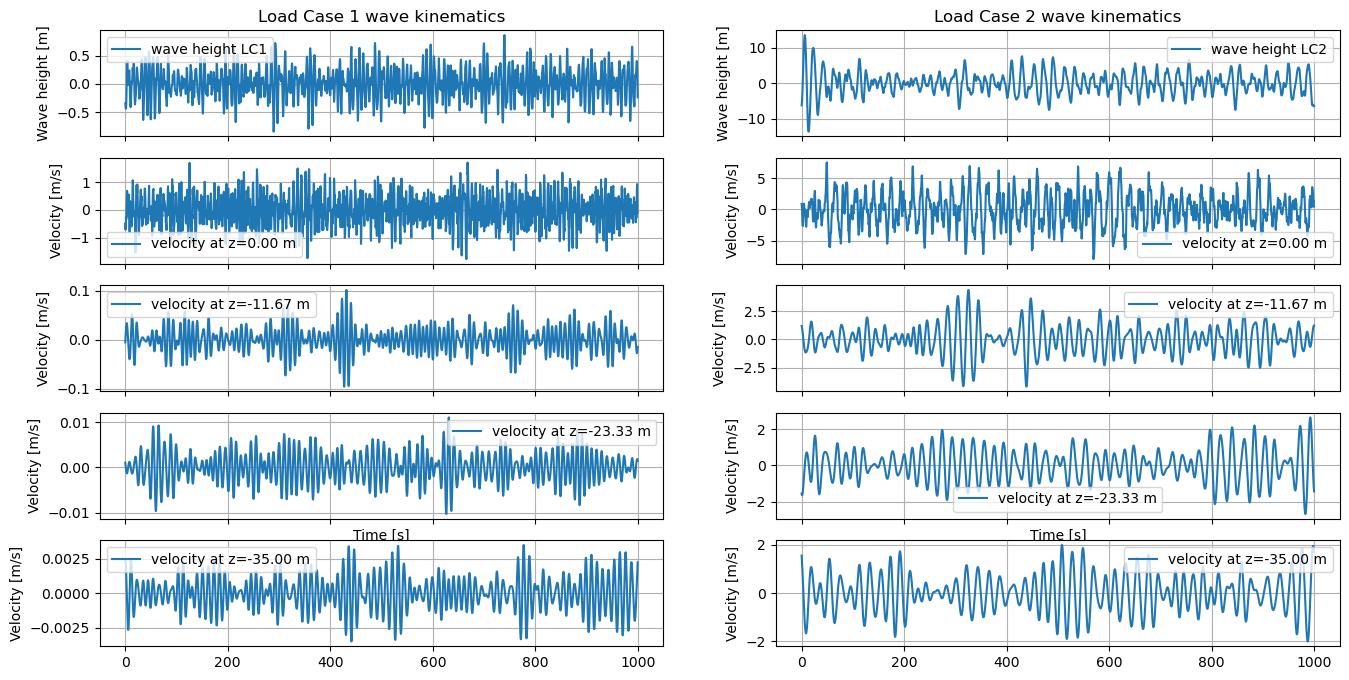

In [23]:
# Create spectra for velocities at different heights
z_nodes_water = z_nodes[z_nodes <= 0]
S_u_wave_LC1 = np.zeros((len(z_nodes_water), len(f_jonswap)))
S_w_wave_LC1 = np.zeros((len(z_nodes_water), len(f_jonswap)))
S_u_wave_LC2 = np.zeros((len(z_nodes_water), len(f_jonswap)))
S_w_wave_LC2 = np.zeros((len(z_nodes_water), len(f_jonswap)))

for i, z in enumerate(z_nodes_water):
    for j, f in enumerate(f_jonswap):
        transfer_function_u = u_wave_particle(1, f, h, z, 0, 0, amplitude=True)
        transfer_function_w = w_wave_particle(1, f, h, z, 0, 0, amplitude=True)
        
        S_u_wave_LC1[i, j] = transfer_function_u**2 * S_JS_1[j]
        S_w_wave_LC1[i, j] = transfer_function_w**2 * S_JS_1[j]
        S_u_wave_LC2[i, j] = transfer_function_u**2 * S_JS_2[j]
        S_w_wave_LC2[i, j] = transfer_function_w**2 * S_JS_2[j]   

# Create time series for wave heights for load cases 1 and 2
time, time_series_jonswap_LC1 = generate_time_series(S_JS_1, f_jonswap)
time, time_series_jonswap_LC2 = generate_time_series(S_JS_2, f_jonswap)

# Create time series for velocities at different heights for load cases 1 and 2
velocity_series_u_LC1 = np.zeros((len(z_nodes_water), len(time)))
velocity_series_u_LC2 = np.zeros((len(z_nodes_water), len(time)))
velocity_series_w_LC1 = np.zeros((len(z_nodes_water), len(time)))
velocity_series_w_LC2 = np.zeros((len(z_nodes_water), len(time)))

for i, z in enumerate(z_nodes_water):
    time, velocity_series_u_LC1[i] = generate_time_series(S_u_wave_LC1[i], f_jonswap)
    time, velocity_series_u_LC2[i] = generate_time_series(S_u_wave_LC2[i], f_jonswap)
    time, velocity_series_w_LC1[i] = generate_time_series(S_w_wave_LC1[i], f_jonswap)
    time, velocity_series_w_LC2[i] = generate_time_series(S_w_wave_LC2[i], f_jonswap)

# Plot the results
fig, ax = plt.subplots(5,2, figsize=(16, 8), sharex=True)

ax[0][0].plot(time, time_series_jonswap_LC1, label=f'wave height LC1')
ax[0][1].plot(time, time_series_jonswap_LC2, label=f'wave height LC2')

ax[1][0].plot(time, velocity_series_u_LC1[3], label=f'velocity at z={z_nodes_water[3]:.2f} m')
ax[1][1].plot(time, velocity_series_u_LC2[3], label=f'velocity at z={z_nodes_water[3]:.2f} m')

ax[2][0].plot(time, velocity_series_u_LC1[2], label=f'velocity at z={z_nodes_water[2]:.2f} m')
ax[2][1].plot(time, velocity_series_u_LC2[2], label=f'velocity at z={z_nodes_water[2]:.2f} m')

ax[3][0].plot(time, velocity_series_u_LC1[1], label=f'velocity at z={z_nodes_water[1]:.2f} m')
ax[3][1].plot(time, velocity_series_u_LC2[1], label=f'velocity at z={z_nodes_water[1]:.2f} m')

ax[4][0].plot(time, velocity_series_u_LC1[0], label=f'velocity at z={z_nodes_water[0]:.2f} m')
ax[4][1].plot(time, velocity_series_u_LC2[0], label=f'velocity at z={z_nodes_water[0]:.2f} m')

ax[0][0].set_title('Load Case 1 wave kinematics')
ax[0][1].set_title('Load Case 2 wave kinematics')

ax[0][0].set_ylabel('Wave height [m]')
ax[0][1].set_ylabel('Wave height [m]')

ax[1][0].set_ylabel('Velocity [m/s]')
ax[1][1].set_ylabel('Velocity [m/s]')

ax[2][0].set_ylabel('Velocity [m/s]')
ax[2][1].set_ylabel('Velocity [m/s]')

ax[3][0].set_ylabel('Velocity [m/s]')
ax[3][1].set_ylabel('Velocity [m/s]')

ax[4][0].set_ylabel('Velocity [m/s]')
ax[4][1].set_ylabel('Velocity [m/s]')

ax[3][0].set_xlabel('Time [s]')
ax[3][1].set_xlabel('Time [s]')

for i in range(5):
    for j in range(2):
        ax[i][j].grid()
        ax[i][j].legend()

## Question 5

To calculate the force spectrum, we need to define the q loads on all the nodes, based on the generated time series.

In [24]:
# Define force spectra due to waves
def alpha_wave(f, z, d, D):
    g = 9.81
    omega = 2 * np.pi * f
    k = solve_wavenumber(omega, g, d)
    G_z = np.cosh(k * (d + z)) / np.sinh(k * d)
    return np.pi/4* D**2 * 1000 * omega**2 * G_z

S_F_wave_LC1 = np.zeros((len(z_nodes_water), len(f_jonswap)))
S_F_wave_LC2 = np.zeros((len(z_nodes_water), len(f_jonswap)))

for i, z in enumerate(z_nodes_water):
    for j, f in enumerate(f_jonswap):
        S_F_wave_LC1[i, j] = (alpha_wave(f, z, h, d))**2 * S_JS_1[j]
        S_F_wave_LC2[i, j] = (alpha_wave(f, z, h, d))**2 * S_JS_2[j]

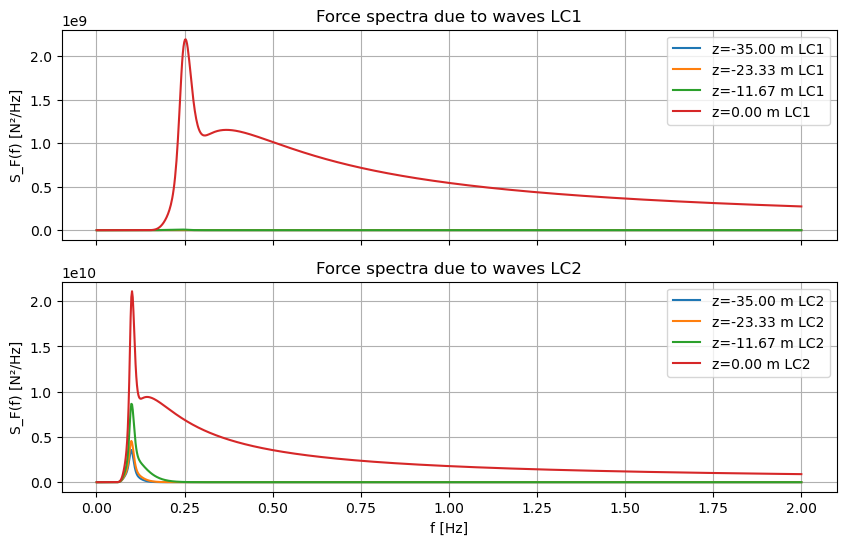

In [25]:
fig, ax = plt.subplots(2,1, figsize=(10, 6), sharex=True)
for i, z in enumerate(z_nodes_water):
    ax[0].plot(f_jonswap, S_F_wave_LC1[i], label=f'z={z:.2f} m LC1')
    ax[1].plot(f_jonswap, S_F_wave_LC2[i], label=f'z={z:.2f} m LC2')

ax[0].set_title('Force spectra due to waves LC1')
ax[1].set_title('Force spectra due to waves LC2')
ax[0].set_ylabel('S_F(f) [N²/Hz]')
ax[1].set_ylabel('S_F(f) [N²/Hz]')
ax[1].set_xlabel('f [Hz]')
ax[0].grid()
ax[1].grid()
ax[0].legend()
ax[1].legend();

Reynolds number = U_bar * D / viscosity_air = 65 * 7 / 1.813E-5 = 25096525 = 2.5E7 -> C_D = 0.6
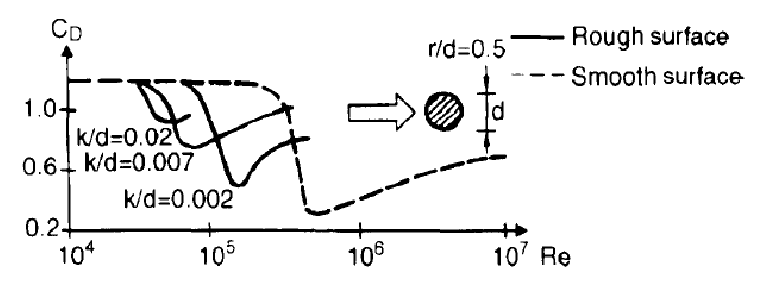

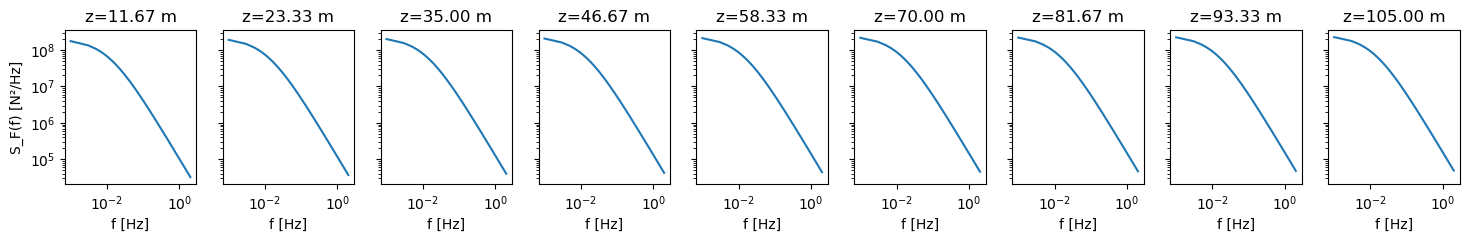

In [26]:
def alpha_wind(z, D):
    C_D = 0.6
    rho_air = 1.225  # Density of air [kg/m³]
    return rho_air * D * U_bar(z, u_star, k, z_0) * C_D

    
S_F_wind = np.zeros((len(z_nodes_air), len(f_kaimal)))

for i, z in enumerate(z_nodes_air):
    for j, f in enumerate(f_kaimal):
        S_F_wind[i, j] = (alpha_wind(z, d))**2 * S_wind_cross[i, i, j]

        
fig, ax = plt.subplots(1,9, figsize=(18,2), sharey=True)
for i, z in enumerate(z_nodes_air):
    ax[i].loglog(f_jonswap, S_F_wind[i], label=f'z={z:.2f} m LC1')
    ax[i].set_title(f'z={z:.2f} m')
    ax[i].set_xlabel('f [Hz]')
ax[0].set_ylabel('S_F(f) [N²/Hz]');

In [27]:
# calculate dynamic stiffness matrix
frequencies = f_kaimal

K_d = np.zeros((ndofs, ndofs, len(frequencies)), dtype=complex)

for i, f in enumerate(frequencies):
    omega = 2 * np.pi * f
    K_d[:,:,i] = K - omega**2 * M + 1j * omega * C_d

In [28]:
# define total force spectrum
S_F_total_LC1 = np.zeros((nn*2, len(frequencies)))
S_F_total_LC2 = np.zeros((nn*2, len(frequencies)))

for i in range(int(nn)):
    if i < 4:
        S_F_total_LC1[i*2] = S_F_wave_LC1[i]
        S_F_total_LC2[i*2] = S_F_wave_LC2[i]
    else:
        S_F_total_LC1[i*2] = S_F_wind[i-4]
        S_F_total_LC2[i*2] = S_F_wind[i-4]

In [29]:
SF_e_LC1 = 1/(rho*A) * M @ S_F_total_LC1
SF_e_LC2 = 1/(rho*A) * M @ S_F_total_LC2

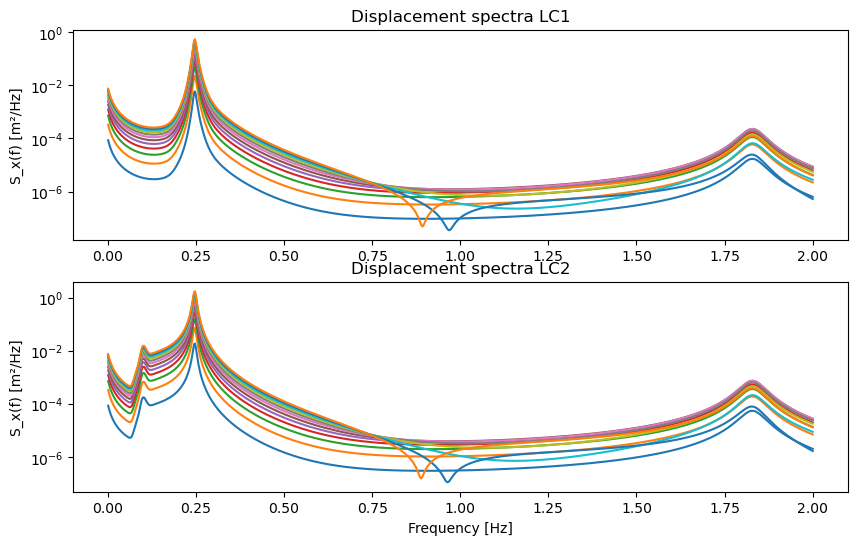

In [30]:
free_dofs = np.arange(2,ndofs)

Sx_LC1 = np.zeros((len(free_dofs), len(frequencies)), dtype=complex)
Sx_LC2 = np.zeros((len(free_dofs), len(frequencies)), dtype=complex)

# for every frequency
for i, f in enumerate(frequencies):
    omega = 2 * np.pi * f
    Kd_i = K_d[:,:,i]
    Kd_i_ff = Kd_i[np.ix_(free_dofs, free_dofs)]  # Extract the free DOFs part of the stiffness matrix
    
    # Calculate the force vector for the current frequency
    SF_e_LC1_i = SF_e_LC1[:, i]
    SF_e_LC2_i = SF_e_LC2[:, i]
    SF_e_LC1_i_ff = SF_e_LC1_i[free_dofs]
    SF_e_LC2_i_ff = SF_e_LC2_i[free_dofs]
    
    # Solve the system of equations
    Sx_LC1[:, i] = np.linalg.inv(Kd_i_ff) @ SF_e_LC1_i_ff @ np.conjugate(np.linalg.inv(Kd_i_ff))
    Sx_LC2[:, i] = np.linalg.inv(Kd_i_ff) @ SF_e_LC2_i_ff @ np.conjugate(np.linalg.inv(Kd_i_ff))

Sx_LC1_global = np.zeros((ndofs, len(frequencies)), dtype=complex)
Sx_LC2_global = np.zeros((ndofs, len(frequencies)), dtype=complex)

# Insert the results back into the global displacement vector
Sx_LC1_global[free_dofs, :] = Sx_LC1
Sx_LC2_global[free_dofs, :] = Sx_LC2

# Plot the results
fig, ax = plt.subplots(2, 1, figsize=(10, 6))
for i in range(nn-1):
    ax[0].semilogy(frequencies, np.abs(Sx_LC1[i*2]), label=f'Displacement DOF {free_dofs[i]} LC1')
    ax[1].semilogy(frequencies, np.abs(Sx_LC2[i*2]), label=f'Displacement DOF {free_dofs[i]} LC2')
    
ax[0].set_title('Displacement spectra LC1')
ax[1].set_title('Displacement spectra LC2')
ax[1].set_xlabel('Frequency [Hz]')
ax[0].set_ylabel('S_x(f) [m²/Hz]')
ax[1].set_ylabel('S_x(f) [m²/Hz]');

In [51]:
# compute moment at mudline
# moment at mudline is dependent on dofs of node 0 and 1.
S_M_mudline_LC1 = np.zeros(len(frequencies))
S_M_mudline_LC2 = np.zeros(len(frequencies))

for i, f in enumerate(frequencies):
    # local z coordinate at mudline
    z_mud = 0.0
    
    # indices of the dofs that contribute to the moment at the mudline
    elem_dofs = np.array([0,1,2,3])
    
    S_M_LC1_i = 0
    S_M_LC2_i = 0
    
    # loop over the dofs of the first element
    for j in range(4):
        S_M_LC1_i += ((E*I * ddN_k[j](z_mud))**2 * Sx_LC1_global[elem_dofs[j], i]).T[0]
        S_M_LC2_i += ((E*I * ddN_k[j](z_mud))**2 * Sx_LC2_global[elem_dofs[j], i]).T[0]
    
    S_M_mudline_LC1[i] = S_M_LC1_i.real
    S_M_mudline_LC2[i] = S_M_LC2_i.real

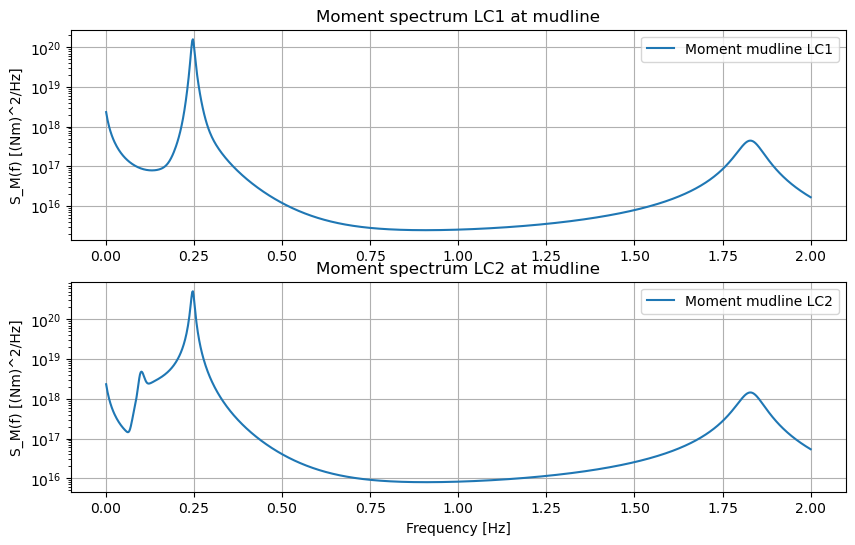

In [52]:
# Plot the results
fig, ax = plt.subplots(2, 1, figsize=(10, 6))

ax[0].semilogy(frequencies, S_M_mudline_LC1, label=f'Moment mudline LC1')
ax[1].semilogy(frequencies, S_M_mudline_LC2, label=f'Moment mudline LC2')
    
ax[0].set_title('Moment spectrum LC1 at mudline')
ax[1].set_title('Moment spectrum LC2 at mudline')
ax[1].set_xlabel('Frequency [Hz]')
ax[0].set_ylabel('S_M(f) [(Nm)^2/Hz]')
ax[1].set_ylabel('S_M(f) [(Nm)^2/Hz]')

ax[0].grid()
ax[1].grid()
ax[0].legend()
ax[1].legend();

# Question 6

In [33]:
U_bar_vector = [U_bar(z, u_star, k, z_0) for z in z_nodes_air]

In [34]:
# compute time series for turbulence accelerations
velocity_LC1_dot = np.zeros((len(z_nodes_air), len(time)))
velocity_LC2_dot = np.zeros((len(z_nodes_air), len(time)))

for i, z in enumerate(z_nodes_water):
    velocity_LC1_dot[i] = np.gradient(velocity_series_u_LC1[i], time)
    velocity_LC2_dot[i] = np.gradient(velocity_series_u_LC2[i], time)

In [35]:
# Turn time series into functions of time with interpolation
from scipy.interpolate import interp1d
velocity_series_u_LC1_interp = [interp1d(time, velocity_series_u_LC1[i], kind='linear') for i in range(len(z_nodes_water))]
velocity_series_u_LC2_interp = [interp1d(time, velocity_series_u_LC2[i], kind='linear') for i in range(len(z_nodes_water))]

velocity_LC1_dot_interp = [interp1d(time, velocity_LC1_dot[i], kind='linear') for i in range(len(z_nodes_water))]
velocity_LC2_dot_interp = [interp1d(time, velocity_LC2_dot[i], kind='linear') for i in range(len(z_nodes_water))]

wind_turbulence_interp = [interp1d(time, wind_turbulence[i], kind='linear') for i in range(len(z_nodes_air))]

In [36]:
# use split wave signal function from lecture assignments
def split_wave_signal(w):
    zero_crossings = np.where(np.diff(np.signbit(w)))[0]

    Nw = len(zero_crossings) // 2 - 1 # number of waves
    T = np.zeros(Nw)
    H = np.zeros(Nw)

    for i in range(0, Nw):
        i_start = zero_crossings[2 * i]
        i_end = zero_crossings[2 * (i + 1)]
        T[i] = t[i_end] - t[i_start]
        H[i] = np.max(w[i_start:i_end]) - np.min(w[i_start:i_end])

    return T, H

def wave_velocity(T, H):
    g = 8.91
    omega = 2 * np.pi / T
    k = solve_wavenumber(omega, g, h)
    
    return H/2 * omega * np.cosh(k * h)/np.sinh(k * h)

In [37]:
# compute mean wave length, wave height and wave velocity for both load cases
w_vector = [time_series_jonswap_LC1, time_series_jonswap_LC2]
t = time

Hs_vector = []
T_mean_vector = []
Hmax_vector = []
U_mean_vector = []

for i, w in enumerate(w_vector):
    T, H = split_wave_signal(w)
    H_sorted = np.sort(H)
    H_length = len(H)
    
    # Reporting the results
    print(f"Time Series {i+1}: (N_periods = {T.size})")
    
    # Determine Significant wave height (Hs)
    Hs = np.mean(H_sorted[2*H_length//3:])
    Hs_vector.append(Hs)
    print(f"Significant wave height (Hs): {Hs:.2f} m")
    
    # Determine Mean wave period
    T_mean = np.mean(T)
    T_mean_vector.append(T_mean)
    print(f"Mean wave period (T_mean): {T_mean:.2f} s")
    
    # Determine max wave height (Hmax)
    Hmax = np.max(H)
    Hmax_vector.append(Hmax)
    print(f"Max wave height (Hmax): {Hmax:.2f} m")
    
    # Determine mean wave velocity
    u_vector = []
    for H, T in zip(H, T):
        u_vector.append(wave_velocity(T, H))
    U_mean = np.mean(u_vector)
    U_mean_vector.append(U_mean)    
    print(f"Mean wave velocity : {U_mean:.2f} m/s", end="\n\n")

Time Series 1: (N_periods = 160)
Significant wave height (Hs): 1.06 m
Mean wave period (T_mean): 6.20 s
Max wave height (Hmax): 1.50 m
Mean wave velocity : 0.33 m/s

Time Series 2: (N_periods = 63)
Significant wave height (Hs): 11.97 m
Mean wave period (T_mean): 15.58 s
Max wave height (Hmax): 27.13 m
Mean wave velocity : 2.07 m/s



In [38]:
# compute wave averaged KC values
for i in range(2):
    print(f"Wave averaged KC value for time series {i+1}: {U_mean_vector[i] * T_mean_vector[i] / d:.2f}")

Wave averaged KC value for time series 1: 0.30
Wave averaged KC value for time series 2: 4.60


The KC number for LC1 is smaller than 3 which means that the inertia term is dominant and the drag term can be assumed to be zero.

The KC number for LC2 falls between 3 and 15 which means that the drag term must be included but can be linearized.

In [39]:
def F_wind(U_bar, u, x_dot):
    rho_air = 1.225  # Density of air [kg/m³]
    C_D = 0.6  # Drag coefficient
    return 0.5 * rho_air * C_D * (U_bar**2 + 2 * U_bar * u - 2 * U_bar * x_dot)

def F_wave(u, u_dot, x_dot):
    rho_water = 1000
    C_D = 0.6
    f_I = 0.25 * rho_water * np.pi * d**2 * 2.0 * u_dot
    f_D = 0.5 * rho_water * d * C_D * abs(u - x_dot) * (u - x_dot)
    return f_I + f_D

def F_total(t, u_wind, u_wave, u_wave_dot, x_dot):
    
    F_vector = np.zeros(nn*2)
    for i in range(int(nn)):
        if i < 4:
            F_vector[i*2] = F_wave(u_wave[i](t), u_wave_dot[i](t), x_dot[i])
        else:
            F_vector[i*2] = F_wind(U_bar_vector[i-4], u_wind[i-4](t), x_dot[i])
            
    return F_vector

In [45]:
# include relative kinematics in mass matrix
rho_water = 1000  # Density of water [kg/m³]

# Add extra mass contribution due to wave kinematics
M_mod = M.copy()
M_mod[0:8:2, 0:8:2] += np.diag(np.ones(4) * 0.25 * np.pi * d**2 * rho_water)

# Reduce matrices to free DOFs
M_mod_r = M_mod[np.ix_(free_dofs, free_dofs)]
K_r = K[np.ix_(free_dofs, free_dofs)]
C_d_r = C_d[np.ix_(free_dofs, free_dofs)]

# Precompute inverse of reduced mass matrix
inv_M_mod_r = np.linalg.inv(M_mod_r)


def system_LC1(t, y):
    x = y[:len(free_dofs)]
    x_dot = y[len(free_dofs):]
    
    f_D = F_total(t, wind_turbulence_interp, velocity_series_u_LC1_interp, velocity_LC1_dot_interp, x_dot)
    f_D_e = 1/(rho*A) * M @ f_D
    f_D_e_r = f_D_e[free_dofs]
    
    dxdt = x_dot
    dx_dotdt = inv_M_mod_r @ (-K_r @ x - C_d_r @ x_dot + f_D_e_r)
    
    return np.concatenate((dxdt, dx_dotdt))

# Initial conditions
y0 = np.zeros(len(free_dofs)*2)  # Initial displacements and velocities
t0 = 0
t_end = 300  # End time for the simulation
time_eval = np.linspace(t0, t_end, 3000)  # Time vector for the simulation

sol1 = scipy.integrate.solve_ivp(system_LC1, [t0, t_end], y0, t_eval=time_eval, method='BDF')

In [46]:
def system_LC2(t, y):
    x = y[:len(free_dofs)]
    x_dot = y[len(free_dofs):]
    
    f_D = F_total(t, wind_turbulence_interp, velocity_series_u_LC2_interp, velocity_LC2_dot_interp, x_dot)
    f_D_e = 1/(rho*A) * M @ f_D
    f_D_e_r = f_D_e[free_dofs]
    
    dxdt = x_dot
    dx_dotdt = inv_M_mod_r @ (-K_r @ x - C_d_r @ x_dot + f_D_e_r)
    
    return np.concatenate((dxdt, dx_dotdt))

# Initial conditions
y0 = np.zeros(len(free_dofs)*2)  # Initial displacements and velocities
t0 = 0
t_end = 300  # End time for the simulation
time_eval = np.linspace(t0, t_end, 3000)  # Time vector for the simulation

sol2 = scipy.integrate.solve_ivp(system_LC2, [t0, t_end], y0, t_eval=time_eval, method='BDF')

In [47]:
# compute moment at mudline
# moment at mudline is dependent on dofs of node 0 and 1.
M_mudline_LC1 = np.zeros(len(time_eval))
M_mudline_LC2 = np.zeros(len(time_eval))

for i, t in enumerate(time_eval):
    # local z coordinate at mudline
    z_mud = 0.0
    
    # indices of the dofs that contribute to the moment at the mudline
    elem_dofs = np.array([0,1,2,3])
    
    M_LC1_i = 0
    M_LC2_i = 0
    
    # loop over the dofs of the first element
    for j in range(4):
        M_LC1_i += (E*I * ddN_k[j](z_mud) * sol1.y[elem_dofs[j], i]).T[0]
        M_LC2_i += (E*I * ddN_k[j](z_mud) * sol2.y[elem_dofs[j], i]).T[0]
    
    M_mudline_LC1[i] = M_LC1_i
    M_mudline_LC2[i] = M_LC2_i

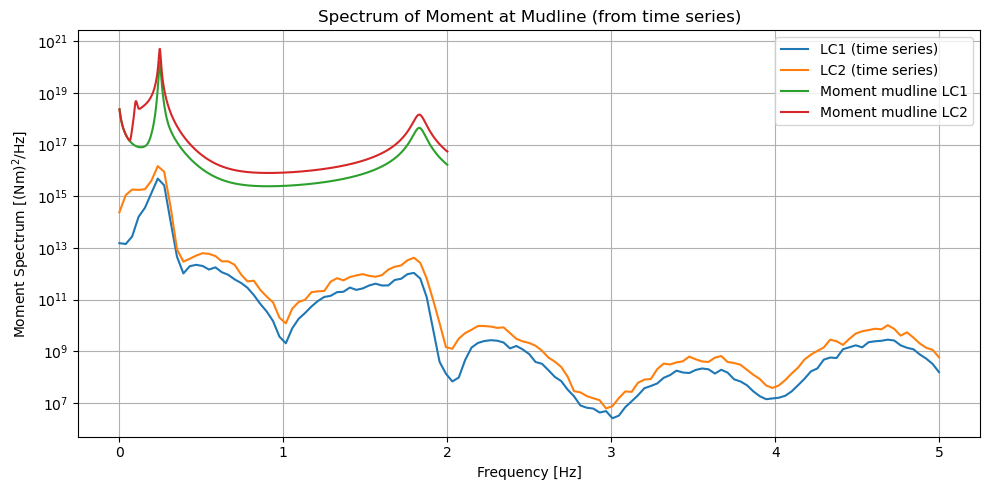

In [ ]:
from scipy.signal import welch

# The moment at the mudline time series for both load cases
# M_mudline_LC1 and M_mudline_LC2 are already computed in cell 54

# Use Welch's method to estimate the power spectral density
fs = 1 / (time_eval[1] - time_eval[0])  # Sampling frequency from time vector

f_mudline_LC1, S_M_mudline_LC1_ts = welch(M_mudline_LC1, fs=fs, nperseg=256)
f_mudline_LC2, S_M_mudline_LC2_ts = welch(M_mudline_LC2, fs=fs, nperseg=256)

# Plot the spectra
plt.figure(figsize=(10, 5))
plt.semilogy(f_mudline_LC1, S_M_mudline_LC1_ts, label='LC1 (time series)')
plt.semilogy(f_mudline_LC2, S_M_mudline_LC2_ts, label='LC2 (time series)')
plt.semilogy(frequencies, S_M_mudline_LC1, label=f'Moment mudline LC1 (frequency domain)')
plt.semilogy(frequencies, S_M_mudline_LC2, label=f'Moment mudline LC2 (frequency domain)')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Moment Spectrum [(Nm)$^2$/Hz]')
plt.title('Spectrum of Moment at Mudline (from time series)')
plt.grid()
plt.legend()
plt.tight_layout()

c:\Users\bart\anaconda3\envs\slender\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


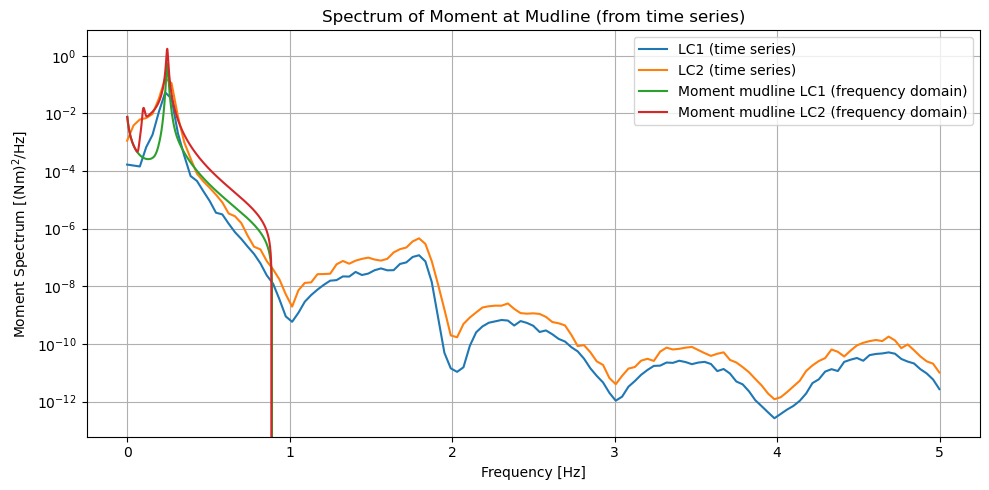

In [56]:
from scipy.signal import welch

# The moment at the mudline time series for both load cases
# M_mudline_LC1 and M_mudline_LC2 are already computed in cell 54

# Use Welch's method to estimate the power spectral density
fs = 1 / (time_eval[1] - time_eval[0])  # Sampling frequency from time vector

f_mudline_LC1, S_x_top_LC1_ts = welch(sol1.y[22], fs=fs, nperseg=256)
f_mudline_LC2, S_x_top_LC2_ts = welch(sol2.y[22], fs=fs, nperseg=256)

# Plot the spectra
plt.figure(figsize=(10, 5))
plt.semilogy(f_mudline_LC1, S_x_top_LC1_ts, label='LC1 (time series)')
plt.semilogy(f_mudline_LC2, S_x_top_LC2_ts, label='LC2 (time series)')
plt.semilogy(frequencies, Sx_LC1[22], label=f'Moment mudline LC1 (frequency domain)')
plt.semilogy(frequencies, Sx_LC2[22], label=f'Moment mudline LC2 (frequency domain)')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Moment Spectrum [(Nm)$^2$/Hz]')
plt.title('Spectrum of Moment at Mudline (from time series)')
plt.grid()
plt.legend()
plt.tight_layout()

In [44]:
# from matplotlib.animation import FuncAnimation
# from IPython.display import HTML

# # Animation for Load Case 1 (sol1)
# fig1, ax1 = plt.subplots(figsize=(8, 5))
# line1, = ax1.plot([], [], marker='o')
# ax1.set_xlim(np.min(sol1.y[::2, :]), np.max(sol1.y[::2, :]))
# ax1.set_ylim(np.min(xn), np.max(xn))
# ax1.set_xlabel('Displacement [m]')
# ax1.set_ylabel('Height [m]')
# ax1.set_title('Wind Turbine Displacement Animation (Load Case 1)')
# ax1.grid()

# def init1():
#     line1.set_data([], [])
#     return line1,

# def update1(frame):
#     displacement = np.zeros(nn)
#     for i in range(nn-1):
#         displacement[i+1] = sol1.y[i*2, frame]
#     line1.set_data(displacement, xn)
#     ax1.set_title(f'Wind Turbine Displacement at t = {sol1.t[frame]:.2f} s (LC1)')
#     return line1,

# ani1 = FuncAnimation(fig1, update1, frames=sol1.y.shape[1], init_func=init1, blit=True, interval=100)

# display(HTML(ani1.to_jshtml()))

# # Animation for Load Case 2 (sol2)
# fig2, ax2 = plt.subplots(figsize=(8, 5))
# line2, = ax2.plot([], [], marker='o')
# ax2.set_xlim(np.min(sol2.y[::2, :]), np.max(sol2.y[::2, :]))
# ax2.set_ylim(np.min(xn), np.max(xn))
# ax2.set_xlabel('Displacement [m]')
# ax2.set_ylabel('Height [m]')
# ax2.set_title('Wind Turbine Displacement Animation (Load Case 2)')
# ax2.grid()

# def init2():
#     line2.set_data([], [])
#     return line2,

# def update2(frame):
#     displacement = np.zeros(nn)
#     for i in range(nn-1):
#         displacement[i+1] = sol2.y[i*2, frame]
#     line2.set_data(displacement, xn)
#     ax2.set_title(f'Wind Turbine Displacement at t = {sol2.t[frame]:.2f} s (LC2)')
#     return line2,

# ani2 = FuncAnimation(fig2, update2, frames=sol2.y.shape[1], init_func=init2, blit=True, interval=100)

# display(HTML(ani2.to_jshtml()))
